# Assignment: Cluster Analysis

In [12]:
from datetime import datetime, timedelta
print(f'Updated {datetime.now().strftime("%d.%m.%Y")} / Tatu Erkinjuntti')

Updated 18.11.2025 / Tatu Erkinjuntti


## Learning Objectives
This assignment introduces basics of clustering analysis in unsupervised machine learning implemented with Python programming language. In doing so, you will also learn how to present information clearly and how to document and explain calculation steps created in notebooks.

## Initial information
IT Department in your company has circulated the following dataset across the company. A new way of collecting data has been put into operation but nobody seems to know what to do with data collected. One day the dataset is in your mailbox.

Perform a cluster analysis to the dataset given below. You can also use your own dataset, if you so wish.

Analyse the results carefully and give marketing department instructions how to exploit them in their work.

**NOTE:** In the last assignment I used the Altair library to generate graphs (mostly because I just wanted to try it out), but in this assignment I will stick to the more traditional pyplot as demonstrated in the class lecture.

In [13]:
# Import libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


## Initial examination of data

In [14]:
# Define data location and import data as a data frame.
file_path = "../data/sales_data_sample.csv"
# NOTE: .csv file is not formated in UTF-8...  ISO-8859-1 encoding seems to work.
df = pd.read_csv(file_path, encoding='ISO-8859-1')
# Check the first five row of the data.
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


It seems that we have data on Motorcycle sales. Lets check the PRODUCTLINE column to be sure.

In [15]:
df['PRODUCTLINE'].unique()

array(['Motorcycles', 'Classic Cars', 'Trucks and Buses', 'Vintage Cars',
       'Planes', 'Ships', 'Trains'], dtype=object)

OK, it seems that we have other products than just motorcycles. Lets check for specifics.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


Lets check for NULL values in an accending order.

In [17]:
df.isnull().sum().sort_values(ascending=False)

ADDRESSLINE2        2521
STATE               1486
TERRITORY           1074
POSTALCODE            76
ORDERNUMBER            0
CUSTOMERNAME           0
CONTACTFIRSTNAME       0
CONTACTLASTNAME        0
COUNTRY                0
CITY                   0
ADDRESSLINE1           0
PHONE                  0
PRODUCTCODE            0
QUANTITYORDERED        0
MSRP                   0
PRODUCTLINE            0
YEAR_ID                0
MONTH_ID               0
QTR_ID                 0
STATUS                 0
ORDERDATE              0
SALES                  0
ORDERLINENUMBER        0
PRICEEACH              0
DEALSIZE               0
dtype: int64

It seems that there are columns that contain quite alot of missing values. Since we are dealing with attributes that might not be used in a destination country, my assessment is that for Cluster analysis it is safe to just remove them.

In [18]:
df.drop(columns=['ADDRESSLINE2','STATE','TERRITORY', 'POSTALCODE'], inplace=True)
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,USA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,France,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,France,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,USA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,San Francisco,USA,Brown,Julie,Medium


Before we start selecting attributes for cluster analysis,we might want to consider what are we trying to answer and to who? Since our target group is the marketing department, we might want to know what customers consumes most products and at what frequencies and try to determine categories for targeted marketing. To manage this, lets do a RFM (Recency, Frequency, Monetary) calculation do determine customer segments that might need more attention from the sales department.


## Preparing the data

In [19]:
# Convert 'ORDERDATE' to datetime.
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
# Get the latest date
last_date = df['ORDERDATE'].max()
# Determine the reference end point
now = last_date + timedelta(days=1)

# Group by 'CUSTOMERNAME' to calculate RFM (Recency, Frequency, Monetary)
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE': lambda x: (now - x.max()).days,    # Recency = number of days since the customer made their last purchase
    'ORDERNUMBER': 'nunique',                       # Frequency = total number of orders the customer has placed
    'SALES': 'sum'                                  # Monetary = total amount of money the customer has spent.
})

# Lest rename columns for consistency
rfm.rename(columns={'ORDERDATE': 'Recency (days)','ORDERNUMBER': 'Frequency (Orders)','SALES': 'Monetary (total sales)'}, inplace=True)

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
# Create a new data frame that includes the column names.
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

### Finding the optimal *K* using the 'Elbow method'.

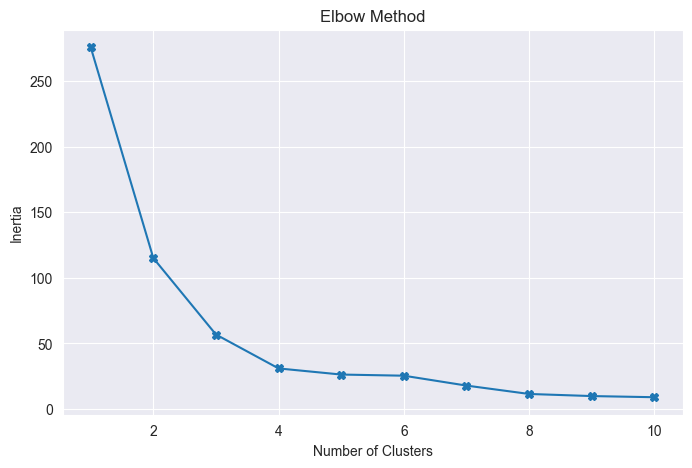

In [20]:
# Determine the optimal number of clusters (K) using the Elbow Method
inertia = []
range_n_clusters = range(1, 11) # Since we use this more than once, lets make it a variable.
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='X')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


It seems that the optimal number of clusters would be 4.

Lets apply K-means using the optimal *K*.

In [21]:
# Apply K-means with K=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled_df) # Find optimal placement for K cluster centroids and assign customer data points.
rfm['Cluster'] = clusters

# Print cluster raw data.
print("Cluster centroids:")
print(rfm.groupby('Cluster').mean())
# Print customer count.
print("\nCustomer Counts per Cluster:")
print(rfm['Cluster'].value_counts())


Cluster centroids:
         Recency (days)  Frequency (Orders)  Monetary (total sales)
Cluster                                                            
0             51.965517            3.517241           114589.796897
1              2.000000           21.500000           783576.085000
2            449.166667            2.083333            65294.094167
3            202.428571            2.795918            88955.988571

Customer Counts per Cluster:
Cluster
3    49
0    29
2    12
1     2
Name: count, dtype: int64


### Data visualisation

Since we are using three (3) attributes (Recency, Frequency and Monetary), a scatterplot will not suffice to represent the clustered data. Pairplot works better, and displays the results in a single graph.

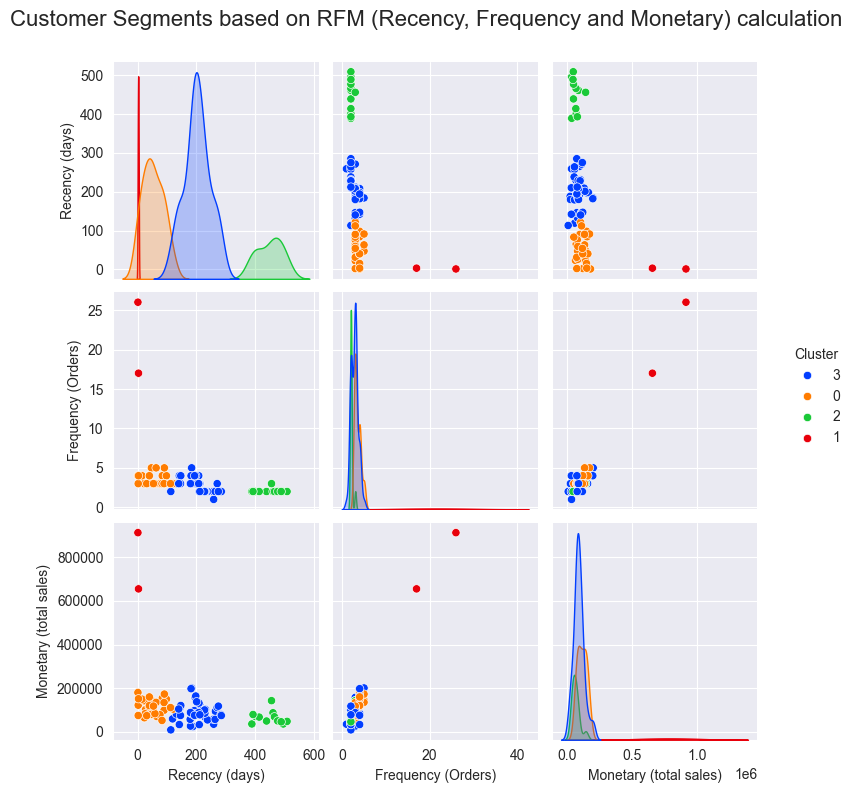

In [22]:
rfm['Cluster'] = rfm['Cluster'].astype(str)
pp_graph = sns.pairplot(rfm, hue='Cluster', palette='bright')
# Add a header for the graph.
pp_graph.figure.suptitle(
    'Customer Segments based on RFM (Recency, Frequency and Monetary) calculation',
    y=1.05,
    fontsize=16
)
plt.show()

## Analysing results

Based on the RFM calculation and K-Means clustering, we can determine four (4) customer categories and form advice for the marketing department:

* Cluster 1 = Most loyal customers (2 customers)
    * Recomendations:
        * This category should have dedicated account managers.
        * No need for extra advertising.
* Cluster 0 = Loyal and active customers (29 customers)
    * Recomendations:
        * Enrolment in loyalty programs for engagement should be considered.
        * Upselling should be focused based on their purchase history.
* Cluster 3 = At risk customers (49 customers)
    * Recomendations:
      * Re-engagement strategy should be a priority.
      * Need focused advertising on discounts and sales.
* Cluster 2 = Lost customers (12 customers)
    * Recomendations:
        * Automated marketing strategy (low cost) advisable.